# Investigating the correlation between high precipitation events and 311 street flooding complaints in New York City
Author: Mark Bauer  

## Objective: Ground-truthing 311 street flooding complaints to actual precipitation levels.

The NYC 311 is a fantastic system to alert the City of non-emergency services such as garbage and trash removal, noise levels, dirty sidewalks, etc. Department of Environmental Protection (DEP) is tasked with responding to 311's Street Flooding complaints. While 311 is not directly intended to measure and observe flooding events, studies show that 311 street flooding complaints might be linked to actual flooding and have the potential to reveal areas that require greater sewer maintenence and resources.

This analysis is designed to test the hypothesis that 311 Street Flooding Complaints are correlated with high precipitation events in Central Park, NYC from 2010 to 2020.

## Links   
NYC 311: https://portal.311.nyc.gov/  
About NYC 311: https://portal.311.nyc.gov/about-nyc-311/  
Street Flooding Complaint Form: https://portal.311.nyc.gov/article/?kanumber=KA-02198

# Data Sources

## 1) 311 Steet Flooding Complaints

311 Service Requests from 2010 to Present: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9


## 2) NOAA Automated Surface/Weather Observing Systems (ASOS/AWOS)
Precipitation Data (Hourly) from 2010 to 2020, NYC, New York (Central Park, 40.779, -73.96925)

Dataset: Automated Surface/Weather Observing Systems (ASOS/AWOS)  
ASOS Mainpage: https://www.ncei.noaa.gov/products/land-based-station/automated-surface-weather-observing-systems  
User guide: https://www.weather.gov/media/asos/aum-toc.pdf


Data retrieved from:  
Iowa State University Environmental Mesonet: https://mesonet.agron.iastate.edu/request/asos/hourlyprecip.phtml?network=NY_ASOS  
Station data: https://mesonet.agron.iastate.edu/sites/site.php?station=NYC&network=NY_ASOS  



Iowa Environmental Mesonet (IEM) Computed Hourly Precipitation Totals
> The IEM attempts to take the METAR reports of precipitation and then provide just the hourly precipitation totals. These totals are not for the true hour (00 to 59 after), but for the hour between the standard METAR reporting time, typically :53 or :54 after. The timestamps displayed are in Central Daylight/Standard Time and for the hour the precipitation fell. So a value for 5 PM would roughly represent the period between 4:53 and 5:53 PM.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
import fiona

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.

In [2]:
%load_ext watermark

In [3]:
%watermark -v -p numpy,pandas,geopandas,geoplot,fiona,matplotlib.pyplot,seaborn

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy            : 1.23.1
pandas           : 1.4.3
geopandas        : 0.11.1
geoplot          : 0.5.1
fiona            : 1.8.21
matplotlib.pyplot: unknown
seaborn          : 0.11.2



Documention for installing watermark: https://github.com/rasbt/watermark

# Retrieve Data

Saving the data locally to my directory.

In [4]:
# path = 'https://mesonet.agron.iastate.edu/cgi-bin/request/hourlyprecip.py?network=NY_ASOS&station=NYC\
# &year1=2010&month1=1&day1=1&year2=2020&month2=12&day2=31&lalo=1&st=1&tz=America%2FNew_York'

# df = pd.read_csv(path)
# df.to_csv('data/hourlyprecip-nyc.csv', index=False)

In [5]:
ls data/

hourlyprecip-nyc.csv


# Read in Data

In [6]:
df = pd.read_csv('data/hourlyprecip-nyc.csv')

print('rows: {:,}\ncolumns: {}'.format(df.shape[0], df.shape[1]))
df.head()

rows: 71,597
columns: 7


,station,network,valid,precip_in,lat,lon,st
0,NYC,NY_ASOS,2010-01-01 01:00,0.0100,40.779,-73.96925,NY
1,NYC,NY_ASOS,2010-01-01 22:00,0.0001,40.779,-73.96925,NY
2,NYC,NY_ASOS,2010-01-01 23:00,0.0100,40.779,-73.96925,NY
3,NYC,NY_ASOS,2010-01-02 00:00,0.0001,40.779,-73.96925,NY
4,NYC,NY_ASOS,2010-01-02 04:00,0.0001,40.779,-73.96925,NY


In [7]:
# My usual sanity checks of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    71597 non-null  object 
 1   network    71597 non-null  object 
 2   valid      71597 non-null  object 
 3   precip_in  71597 non-null  float64
 4   lat        71597 non-null  float64
 5   lon        71597 non-null  float64
 6   st         71597 non-null  object 
dtypes: float64(3), object(4)
memory usage: 3.8+ MB


In [8]:
df.describe()

,precip_in,lat,lon
count,71597.000000,71597.000,71597.00000
mean,0.007600,40.779,-73.96925
std,0.043277,0.000,0.00000
min,0.000000,40.779,-73.96925
25%,0.000000,40.779,-73.96925
50%,0.000000,40.779,-73.96925
75%,0.000000,40.779,-73.96925
max,1.660000,40.779,-73.96925


In [9]:
# to date_time
df['date_time'] = pd.to_datetime(df['valid'], infer_datetime_format=True)
df = df.sort_values(by='date_time').reset_index(drop=True)

# sanity check
df.head(10)

,station,network,valid,precip_in,lat,lon,st,date_time
0,NYC,NY_ASOS,2010-01-01 01:00,0.0100,40.779,-73.96925,NY,2010-01-01 01:00:00
1,NYC,NY_ASOS,2010-01-01 22:00,0.0001,40.779,-73.96925,NY,2010-01-01 22:00:00
2,NYC,NY_ASOS,2010-01-01 23:00,0.0100,40.779,-73.96925,NY,2010-01-01 23:00:00
3,NYC,NY_ASOS,2010-01-02 00:00,0.0001,40.779,-73.96925,NY,2010-01-02 00:00:00
4,NYC,NY_ASOS,2010-01-02 04:00,0.0001,40.779,-73.96925,NY,2010-01-02 04:00:00
5,NYC,NY_ASOS,2010-01-02 05:00,0.0001,40.779,-73.96925,NY,2010-01-02 05:00:00
6,NYC,NY_ASOS,2010-01-02 06:00,0.0001,40.779,-73.96925,NY,2010-01-02 06:00:00
7,NYC,NY_ASOS,2010-01-03 09:00,0.0001,40.779,-73.96925,NY,2010-01-03 09:00:00
8,NYC,NY_ASOS,2010-01-03 10:00,0.0001,40.779,-73.96925,NY,2010-01-03 10:00:00
9,NYC,NY_ASOS,2010-01-03 14:00,0.0001,40.779,-73.96925,NY,2010-01-03 14:00:00


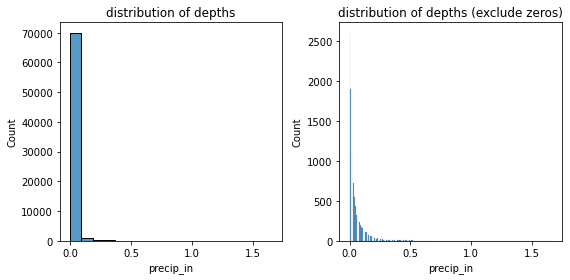

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(df['precip_in'], ax=axs[0])
axs[0].set_title('distribution of depths')

# removing zeros
sns.histplot(data=df.loc[df['precip_in'] > 0], x='precip_in', ax=axs[1])
axs[1].set_title('distribution of depths (exclude zeros)')

fig.tight_layout()

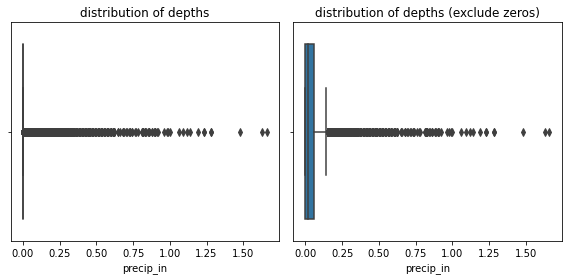

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.boxplot(x=df["precip_in"], ax=axs[0])
axs[0].set_title('distribution of depths')

# removing zeros
sns.boxplot(data=df.loc[df["precip_in"] > 0], x='precip_in', ax=axs[1])
axs[1].set_title('distribution of depths (exclude zeros)')

fig.tight_layout()

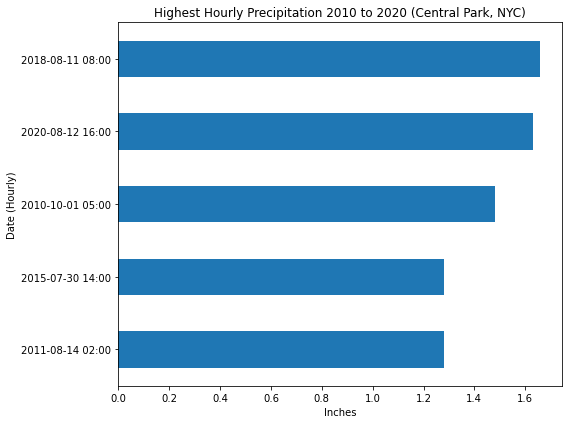

In [12]:
# highest values by date_time in NYC

fig, ax = plt.subplots(figsize=(8, 6))

(df
 .sort_values(by='precip_in', ascending=False)
 .loc[:, ['valid', 'precip_in']]
 .head()
 .sort_values(by='precip_in')
 .plot.barh(x='valid', y='precip_in', ax=ax, legend=False)
)

plt.title('Highest Hourly Precipitation 2010 to 2020 (Central Park, NYC)')
plt.ylabel('Date (Hourly)')
plt.xlabel('Inches')
plt.tight_layout()

Nice tutorial about resampling: https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/resample-time-series-data-pandas-python/

In [13]:
# Resample to hourly precip max and save as new dataframe
one_hour = (
    df
    .set_index('date_time')[['precip_in']]
    .resample('1H')
    .max()
)

# sanity check
one_hour.describe()

,precip_in
count,71589.000000
mean,0.007601
std,0.043279
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.660000


In [14]:
# Resample to 6-hour precip max and save as new dataframe
six_hour = (
    df
    .set_index('date_time')[['precip_in']]
    .resample('6H')
    .max()
)

# sanity check
six_hour.describe()

,precip_in
count,12423.000000
mean,0.022655
std,0.086522
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000100
max,1.660000


# Compare 1-Hour and 6-Hour max precipitation

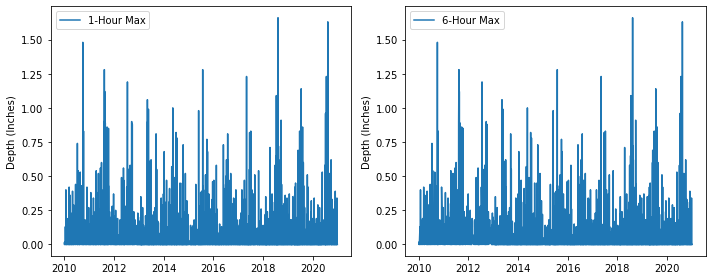

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(data=one_hour, legend=False, palette=('tab:blue', ), ax=axs[0])
sns.lineplot(data=six_hour, legend=False, palette=('tab:blue', ), ax=axs[1])

axs[0].legend(labels=['1-Hour Max'])
axs[1].legend(labels=['6-Hour Max'])

for ax in axs.flat:
    ax.set_xlabel('')
    ax.set_ylabel('Depth (Inches)')

fig.tight_layout()

The plots generally follow the same trend, so we can use one of them to represent our actual precipitation group. Specifically, these intervals can represent our Flash Flooding group.

# Read in NYC 311 Street Flooding Complaints

In [16]:
path = 'https://raw.githubusercontent.com/mebauer/nyc-311-street-flooding/\
main/data/street-flooding-complaints.csv'

complaints_df = pd.read_csv(path, low_memory=False)

print(complaints_df.shape)
complaints_df.head()

(27902, 34)


,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,cross_street_1,...,location,intersection_street_1,intersection_street_2,closed_date,resolution_description,resolution_action_updated_date,location_type,landmark,facility_type,due_date
0,48542220,2020-12-31T15:41:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11420.0,117-17 135 STREET,135 STREET,FOCH BLVD,...,"{'latitude': '40.67703755925495', 'longitude':...",NaN,NaN,2021-01-01T00:20:00.000,Please call 311 for further information. If yo...,2021-01-01T00:20:00.000,NaN,NaN,NaN,NaN
1,48536430,2020-12-31T14:49:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.0,20-24 150 STREET,150 STREET,20 AVE,...,"{'latitude': '40.78072630540092', 'longitude':...",NaN,NaN,2021-01-04T10:15:00.000,The Department of Environment Protection inspe...,2021-01-04T10:15:00.000,NaN,NaN,NaN,NaN
2,48539361,2020-12-31T14:03:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11228.0,7223 8 AVENUE,8 AVENUE,72 ST,...,"{'latitude': '40.62849640806448', 'longitude':...",NaN,NaN,2021-01-02T11:25:00.000,The Department of Environmental Protection has...,2021-01-02T11:25:00.000,NaN,NaN,NaN,NaN
3,48543132,2020-12-31T13:48:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10032.0,NaN,NaN,NaN,...,"{'latitude': '40.841051689545516', 'longitude'...",RIVERSIDE DRIVE,WEST 165 STREET,2020-12-31T14:50:00.000,Please call 311 for further information. If yo...,2020-12-31T14:50:00.000,NaN,NaN,NaN,NaN
4,48536441,2020-12-31T13:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11234.0,3123 FILLMORE AVENUE,FILLMORE AVENUE,E 31 ST,...,"{'latitude': '40.609203447399906', 'longitude'...",NaN,NaN,2021-01-03T10:45:00.000,The Department of Environmental Protection ins...,2021-01-03T10:45:00.000,NaN,NaN,NaN,NaN


In [17]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27902 entries, 0 to 27901
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27902 non-null  int64  
 1   created_date                    27902 non-null  object 
 2   agency                          27902 non-null  object 
 3   agency_name                     27902 non-null  object 
 4   complaint_type                  27902 non-null  object 
 5   descriptor                      27902 non-null  object 
 6   incident_zip                    27045 non-null  float64
 7   incident_address                17865 non-null  object 
 8   street_name                     17865 non-null  object 
 9   cross_street_1                  24148 non-null  object 
 10  cross_street_2                  24137 non-null  object 
 11  address_type                    27896 non-null  object 
 12  city                            

In [18]:
# only one 311 descriptor in this dataset - street flooding
complaints_df['descriptor'].value_counts()

Street Flooding (SJ)    27902
Name: descriptor, dtype: int64

In [19]:
# to date_time
complaints_df['date_time'] = pd.to_datetime(complaints_df['created_date'], infer_datetime_format=True)
complaints_df = complaints_df.sort_values(by='date_time').reset_index(drop=True)

# sanity check
complaints_df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,cross_street_1,...,intersection_street_1,intersection_street_2,closed_date,resolution_description,resolution_action_updated_date,location_type,landmark,facility_type,due_date,date_time
0,15639934,2010-01-02T08:26:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11229.0,39 DARE COURT,DARE COURT,LOIS AVE,...,NaN,NaN,2010-01-03T08:45:00.000,The Department of Environmental Protection ins...,2010-01-03T08:45:00.000,NaN,NaN,NaN,NaN,2010-01-02 08:26:00
1,15640572,2010-01-02T12:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10302.0,NaN,NaN,NEWARK AVE,...,NEWARK AVENUE,RICHMOND TERRACE,2010-01-02T15:12:00.000,Please call 311 for further information. If yo...,2010-01-02T15:12:00.000,NaN,NaN,NaN,1900-01-02T00:00:00.000,2010-01-02 12:00:00
2,15640664,2010-01-02T17:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11436.0,116-14 146 STREET,146 STREET,116 AVE,...,NaN,NaN,2010-01-12T11:00:00.000,The Department of Environment Protection inspe...,2010-01-12T11:00:00.000,NaN,NaN,NaN,NaN,2010-01-02 17:45:00
3,15655327,2010-01-04T16:47:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11428.0,94-18 218 STREET,218 STREET,94 AVE,...,NaN,NaN,2010-01-12T10:35:00.000,The Department of Environment Protection inspe...,2010-01-12T10:35:00.000,NaN,NaN,NaN,NaN,2010-01-04 16:47:00
4,15668560,2010-01-05T10:37:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11234.0,2330 EAST 63 STREET,EAST 63 STREET,OHIO WALK,...,NaN,NaN,2010-01-08T09:00:00.000,The Department of Environment Protection inspe...,2010-01-08T09:00:00.000,NaN,NaN,NaN,NaN,2010-01-05 10:37:00


# 6-Hour Max Depth vs. 6-Hour Complaint Counts

In [20]:
# Resample to 6-hour precip max and save as new dataframe
hour_six_max = (
    df
    .set_index('date_time')[['precip_in']]
    .resample('6H')
    .max()
)

# sanity check
hour_six_max.describe()

,precip_in
count,12423.000000
mean,0.022655
std,0.086522
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000100
max,1.660000


In [21]:
hour_six_max.loc[hour_six_max['precip_in'] > 0, ['rain_flag']] = 1
hour_six_max['rain_flag'] = hour_six_max['rain_flag'].fillna(0)
hour_six_max['rain_flag'] = hour_six_max['rain_flag'].astype(int)

# sanity check
hour_six_max.describe()

,precip_in,rain_flag
count,12423.000000,16069.000000
mean,0.022655,0.197834
std,0.086522,0.398379
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000100,0.000000
max,1.660000,1.000000


In [22]:
# Resample to 6-hour complaint count and save as new dataframe
complaints_hourly = (
    complaints_df
    .set_index('date_time')[['unique_key']]
    .resample('6H')
    .count()
    .rename(columns={'unique_key':'count'})
)

complaints_hourly.head()

,count
date_time,
2010-01-02 06:00:00,1
2010-01-02 12:00:00,2
2010-01-02 18:00:00,0
2010-01-03 00:00:00,0
2010-01-03 06:00:00,0


In [23]:
# merge both datasets on date_time
merged_df = (
    hour_six_max
    .merge(complaints_hourly,
           left_index=True,
           right_index=True,
           how='left')
)

merged_df['count'] = merged_df['count'].fillna(0).astype(int)
merged_df['precip_in'] = merged_df['precip_in'].fillna(0)

# sanity check
merged_df.describe()

,precip_in,rain_flag,count
count,16069.000000,16069.000000,16069.000000
mean,0.017515,0.197834,1.735329
std,0.076664,0.398379,5.792891
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,2.000000
max,1.660000,1.000000,209.000000


# Qualitative Analysis - 311 Complaint vs. Rain Event

In [24]:
complaint_and_rain = len(
    merged_df
    .loc[(merged_df['count'] > 0)
         & (merged_df['rain_flag'] == 1)]
)

complaint_and_norain = len(
    merged_df
    .loc[(merged_df['count'] > 0)
         & (merged_df['rain_flag'] == 0)]
)

nocomplaint_and_rain = len(
    merged_df
    .loc[(merged_df['count'] == 0)
         & (merged_df['rain_flag'] == 1)]
)

nocomplaint_and_norain = len(
    merged_df
    .loc[(merged_df['count'] == 0)
         & (merged_df['rain_flag'] == 0)]
)

print('Total 6-hour intervals: {:,}\n-----'.format(len(merged_df)))
print('There were complaints and it rained: {:,}'.format(complaint_and_rain))
print('There were complaints but it didnt rain: {:,}'.format(complaint_and_norain))
print('There were no complaints but it did rain: {:,}'.format(nocomplaint_and_rain))
print('There were no complaints and it didnt rain: {:,}'.format(nocomplaint_and_norain))

Total 6-hour intervals: 16,069
-----
There were complaints and it rained: 1,957
There were complaints but it didnt rain: 5,216
There were no complaints but it did rain: 1,222
There were no complaints and it didnt rain: 7,674


# Quantitative Analysis - Linear Regression

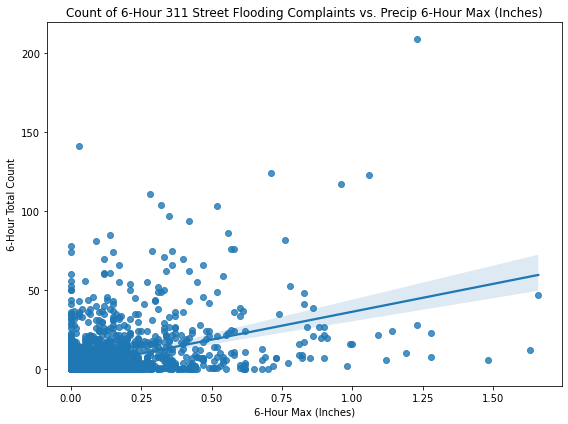

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(data=merged_df, x="precip_in", y="count", ax=ax)

plt.title('Count of 6-Hour 311 Street Flooding Complaints vs. Precip 6-Hour Max (Inches)')
plt.xlabel('6-Hour Max (Inches)')
plt.ylabel('6-Hour Total Count')

plt.tight_layout()

In [26]:
merged_df.corr(method='pearson')

,precip_in,rain_flag,count
precip_in,1.000000,0.460053,0.466905
rain_flag,0.460053,1.000000,0.267990
count,0.466905,0.267990,1.000000


In [27]:
merged_df.corr(method='spearman')

,precip_in,rain_flag,count
precip_in,1.000000,0.992072,0.247605
rain_flag,0.992072,1.000000,0.230233
count,0.247605,0.230233,1.000000


In [28]:
Y = merged_df['count']
X = merged_df['precip_in']
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     4479.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:00:49   Log-Likelihood:                -49052.
No. Observations:               16069   AIC:                         9.811e+04
Df Residuals:                   16067   BIC:                         9.812e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1174      0.041     26.955      0.0

In [29]:
print('Parameters:\n{}'.format(results.params.round(4)))
print('\nR2: {}'.format(results.rsquared.round(4)))

Parameters:
const         1.1174
precip_in    35.2803
dtype: float64

R2: 0.218


# Total Daily Depth vs. Daily Complaint Counts

In [30]:
# Resample to daily precip max and save as new dataframe
daily_total = (
    df
    .set_index('date_time')[['precip_in']]
    .resample('D')
    .sum()
)

# sanity check
daily_total.describe()

,precip_in
count,4018.000000
mean,0.135428
std,0.373793
min,0.000000
25%,0.000000
50%,0.000000
75%,0.050300
max,5.810100


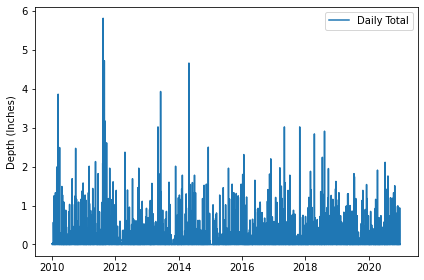

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(data=daily_total, legend=False, palette=('tab:blue', ), ax=ax)

ax.legend(labels=['Daily Total'])
ax.set_xlabel('')
ax.set_ylabel('Depth (Inches)')

plt.tight_layout()

In [32]:
daily_total.loc[daily_total['precip_in'] > 0, ['rain_flag']] = 1
daily_total['rain_flag'] = daily_total['rain_flag'].fillna(0)
daily_total['rain_flag'] = daily_total['rain_flag'].astype(int)

daily_total['precip_in'] = daily_total['precip_in'].fillna(0)

daily_total.head()

,precip_in,rain_flag
date_time,,
2010-01-01,0.0201,1
2010-01-02,0.0004,1
2010-01-03,0.0004,1
2010-01-04,0.0000,0
2010-01-05,0.0001,1


In [33]:
# Resample to daily complaint count and save as new dataframe
complaints_daily = (
    complaints_df
    .set_index('date_time')[['unique_key']]
    .resample('D')
    .count()
    .rename(columns={'unique_key':'count'})
)

complaints_daily.head()

,count
date_time,
2010-01-02,3
2010-01-03,0
2010-01-04,1
2010-01-05,1
2010-01-06,4


In [34]:
# merge dataframes on date_time
merged_df = (
    daily_total
    .merge(complaints_daily,
           left_index=True,
           right_index=True,
           how='left')
)

merged_df['count'] = merged_df['count'].fillna(0).astype(int)
merged_df['precip_in'] = merged_df['precip_in'].fillna(0)

merged_df.head()

,precip_in,rain_flag,count
date_time,,,
2010-01-01,0.0201,1,0
2010-01-02,0.0004,1,3
2010-01-03,0.0004,1,0
2010-01-04,0.0000,0,1
2010-01-05,0.0001,1,1


# Qualitative Analysis - 311 Complaint vs. Rain Event

In [35]:
complaint_and_rain = len(
    merged_df
    .loc[(merged_df['count'] > 0)
         & (merged_df['rain_flag'] == 1)]
)

complaint_and_norain = len(
    merged_df
    .loc[(merged_df['count'] > 0)
         & (merged_df['rain_flag'] == 0)]
)

nocomplaint_and_rain = len(
    merged_df
    .loc[(merged_df['count'] == 0)
         & (merged_df['rain_flag'] == 1)]
)

nocomplaint_and_norain = len(
    merged_df
    .loc[(merged_df['count'] == 0)
         & (merged_df['rain_flag'] == 0)]
)


print('Total days: {:,}\n-----'.format(len(merged_df)))
print('There were complaints and it rained: {:,}'.format(complaint_and_rain))
print('There were complaints but it didnt rain: {:,}'.format(complaint_and_norain))
print('There were no complaints but it did rain: {:,}'.format(nocomplaint_and_rain))
print('There were no complaints and it didnt rain: {:,}'.format(nocomplaint_and_norain))

Total days: 4,018
-----
There were complaints and it rained: 1,511
There were complaints but it didnt rain: 1,964
There were no complaints but it did rain: 114
There were no complaints and it didnt rain: 429


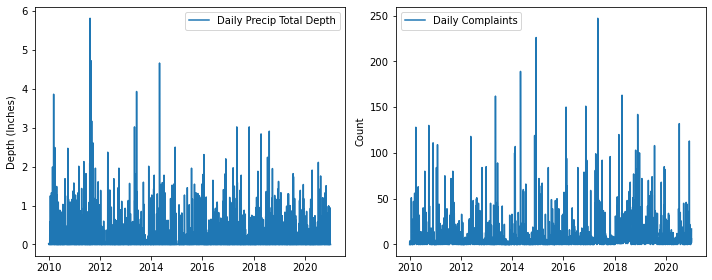

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(data=merged_df, x=merged_df.index, y='precip_in', legend=False, palette=('tab:blue', ), ax=axs[0])
sns.lineplot(data=merged_df, x=merged_df.index, y='count', legend=False, palette=('tab:blue', ), ax=axs[1])

axs[0].legend(labels=['Daily Precip Total Depth'])
axs[1].legend(labels=['Daily Complaints'])

axs[0].set_ylabel('Depth (Inches)')
axs[1].set_ylabel('Count')

[ax.set_xlabel('') for ax in axs.flat]
    
fig.tight_layout()

# Quantitative Analysis - Linear Regression

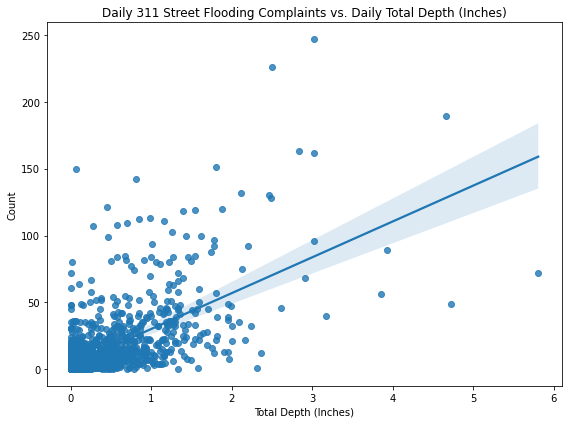

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(data=merged_df, x="precip_in", y="count", ax=ax)

plt.title('Daily 311 Street Flooding Complaints vs. Daily Total Depth (Inches)')
plt.xlabel('Total Depth (Inches)')
plt.ylabel('Count')

plt.tight_layout()

In [38]:
merged_df.corr(method='pearson')

,precip_in,rain_flag,count
precip_in,1.000000,0.439721,0.667650
rain_flag,0.439721,1.000000,0.317658
count,0.667650,0.317658,1.000000


In [39]:
merged_df.corr(method='spearman')

,precip_in,rain_flag,count
precip_in,1.000000,0.957173,0.455491
rain_flag,0.957173,1.000000,0.382689
count,0.455491,0.382689,1.000000


In [40]:
Y = merged_df['count']
X = merged_df['precip_in']
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     3230.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:00:50   Log-Likelihood:                -15396.
No. Observations:                4018   AIC:                         3.080e+04
Df Residuals:                    4016   BIC:                         3.081e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3164      0.187     17.699      0.0

In [41]:
print('Parameters:\n{}'.format(results.params.round(4)))
print('\nR2: {}'.format(results.rsquared.round(4)))

Parameters:
const         3.3164
precip_in    26.7883
dtype: float64

R2: 0.4458


# Weekly Total Depth vs. Weekly Complaint Counts

In [42]:
# Resample to weekly precip max and save as new dataframe
week_total = (
    df
    .set_index('date_time')[['precip_in']]
    .resample('W')
    .sum()
)

# sanity check
week_total.describe()

,precip_in
count,575.000000
mean,0.946349
std,1.025975
min,0.000000
25%,0.200100
50%,0.641000
75%,1.410400
max,7.900200


In [43]:
week_total.loc[week_total['precip_in'] > 0, ['rain_flag']] = 1
week_total['rain_flag'] = week_total['rain_flag'].fillna(0)
week_total['rain_flag'] = week_total['rain_flag'].astype(int)

week_total['precip_in'] = week_total['precip_in'].fillna(0)

# sanity check
week_total.describe()

,precip_in,rain_flag
count,575.000000,575.000000
mean,0.946349,0.944348
std,1.025975,0.229448
min,0.000000,0.000000
25%,0.200100,1.000000
50%,0.641000,1.000000
75%,1.410400,1.000000
max,7.900200,1.000000


In [44]:
# Resample to weekly complaint counts and save as new dataframe
complaints_weekly = (
    complaints_df
    .set_index('date_time')[['unique_key']]
    .resample('W')
    .count()
    .rename(columns={'unique_key':'count'})
)

complaints_weekly.head()

,count
date_time,
2010-01-03,3
2010-01-10,11
2010-01-17,8
2010-01-24,13
2010-01-31,73


In [45]:
# merge on date_time
merged_df = (
    week_total
    .merge(complaints_weekly,
           left_index=True,
           right_index=True,
           how='left')
)

merged_df['count'] = merged_df['count'].fillna(0).astype(int)
merged_df['precip_in'] = merged_df['precip_in'].fillna(0)

# sanity check
merged_df.describe()

,precip_in,rain_flag,count
count,575.000000,575.000000,575.000000
mean,0.946349,0.944348,48.525217
std,1.025975,0.229448,49.102385
min,0.000000,0.000000,0.000000
25%,0.200100,1.000000,17.000000
50%,0.641000,1.000000,31.000000
75%,1.410400,1.000000,60.000000
max,7.900200,1.000000,336.000000


# Qualitative Analysis - 311 Complaint vs. Rain Event

In [46]:
complaint_and_rain = len(
    merged_df
    .loc[(merged_df['count'] > 0)
         & (merged_df['rain_flag'] == 1)]
)

complaint_and_norain = len(
    merged_df
    .loc[(merged_df['count'] > 0)
         & (merged_df['rain_flag'] == 0)]
)

nocomplaint_and_rain = len(
    merged_df
    .loc[(merged_df['count'] == 0)
         & (merged_df['rain_flag'] == 1)]
)

nocomplaint_and_norain = len(
    merged_df
    .loc[(merged_df['count'] == 0)
         & (merged_df['rain_flag'] == 0)]
)


print('Total weeks: {:,}\n-----'.format(len(merged_df)))
print('There were complaints and it rained: {:,}'.format(complaint_and_rain))
print('There were complaints but it didnt rain: {:,}'.format(complaint_and_norain))
print('There were no complaints but it did rain: {:,}'.format(nocomplaint_and_rain))
print('There were no complaints and it didnt rain: {:,}'.format(nocomplaint_and_norain))

Total weeks: 575
-----
There were complaints and it rained: 543
There were complaints but it didnt rain: 31
There were no complaints but it did rain: 0
There were no complaints and it didnt rain: 1


# Quantitative Analysis - Linear Regression

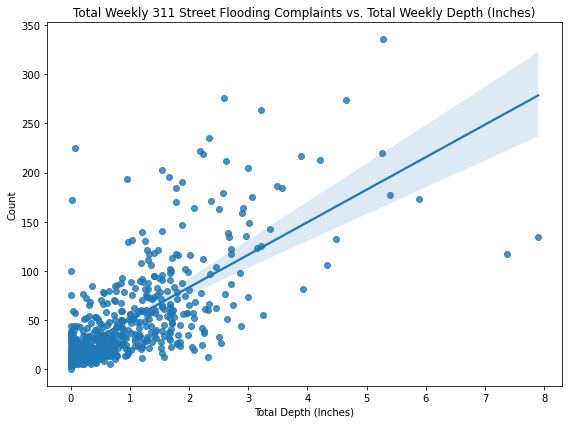

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(data=merged_df, x="precip_in", y="count", ax=ax)

plt.title('Total Weekly 311 Street Flooding Complaints vs. Total Weekly Depth (Inches)')
plt.xlabel('Total Depth (Inches)')
plt.ylabel('Count')

plt.tight_layout()

In [48]:
merged_df.corr(method='pearson')

,precip_in,rain_flag,count
precip_in,1.000000,0.224113,0.691221
rain_flag,0.224113,1.000000,0.138830
count,0.691221,0.138830,1.000000


In [49]:
merged_df.corr(method='spearman')

,precip_in,rain_flag,count
precip_in,1.000000,0.397106,0.704604
rain_flag,0.397106,1.000000,0.204734
count,0.704604,0.204734,1.000000


In [50]:
Y = merged_df['count']
X = merged_df['precip_in']
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     524.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.01e-83
Time:                        11:00:51   Log-Likelihood:                -2867.6
No. Observations:                 575   AIC:                             5739.
Df Residuals:                     573   BIC:                             5748.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.2187      2.016      8.542      0.0

In [51]:
print('Parameters:\n{}'.format(results.params.round(4)))
print('\nR2: {}'.format(results.rsquared.round(4)))

Parameters:
const        17.2187
precip_in    33.0813
dtype: float64

R2: 0.4778
